# Demo 4: FEDS Archived V.S. CAL FIRE California Perimeter All Collection for 2020 August Complex

### Summary

This notebook demonstrates the capabilities of the FEDS-PEC module to compare a local CAL FIRE periemter to a local FEDS perimeter

Sources for demonstration:
- FEDS archived perimeters, labeled as `"public.eis_fire_lf_perimeter_archive"`
- CAL FIRE all california perimeters, treated as historic, labeled as `"california_fire_perimeters_all"`


The FEDS input and reference input can use either a pre-defined setting or can accept (valid) user-written paths to shape files. 
- For Input all settings, please see **section INPUT SETTINGS of README.md**  
- Output settings can also be modified to control if calculations are printed, plotted, and/or stored into a file (with location and file type of choice); for more detail on outputs please see **section OUTPUT SETTINGS of README.md**

### Selected Example + Disclaimer


#### Motivation 



In [2]:
import sys
sys.path.append('../') # local path append

import Utilities
import Input_FEDS
import Input_Reference
import Output_Calculation

from Input_FEDS import InputFEDS
from Input_Reference import InputReference
from Output_Calculation import OutputCalculation
from Utilities import *

In [3]:
# this is the ONLY thing users are intended to modify!
# inputs for searching FEDS and nifc sets

# START TIME
year_start = 2020
month_start = 8
day_start = 15
hour_start = 0
minute_start = 0
second_start = 0
tz_offset_hours_start = 0
tz_offset_minutes_start = 0
utc_offset_start = '00:00'

# END TIME
year_stop = 2020
month_stop = 9
day_stop = 20
hour_stop = 0
minute_stop = 0
second_stop = 0
tz_offset_hours_stop = 0
tz_offset_minutes_stop = 0
utc_offset_stop = '00:00'

# CRS - 4326 RECOMMENDED FEDS FIRE PERIM DEFAULT
crs = 3857 # 4326

# BBOX FOR SEARCH - [lon, lat, lon, lat]
# 40.634026, -123.894958
# 39.529218, -122.290878
search_bbox = ["-123.894958","40.634026","-122.290878","39.529218"]


day_search_range = 7 # acceptable distance to search from feds -> reference (e.g. if refernce polygon is 8 days away, it is not included in calculations)

# FEDS INPUT SETTINGS  # [Change to FEDS Input settings]
feds_title = "firenrt"
feds_collection =  "public.eis_fire_lf_perimeter_archive"
feds_access_type = "api" # or "local
feds_limit = 1000 # amount of features to consider for FEDS API access; warning appears if it misses any entries
feds_filter = False # False or a valid query: e.g. "farea>5 AND duration>2"
feds_apply_finalfire = True # set this to true if you want the only the latest fireID to be taken per unique FireID

# REFERENCE INPUT SETTINGS 
ref_title = "california_fire_perimeters_all" # this is a predefined set example
ref_control_type = "defined" # or "custom"
ref_custom_url = "none" # not custom for demo
ref_custom_read_type = "none"  # not custom for demo
ref_filter = False # False or a valid query

# OUTPUT SETTINGS
maap_username = "ksharonin" # per user, in order to store into user's own public bucket
name_for_output_file = f"firenrt_vs_nifc_interagency_{year_start}_{search_bbox[0]}_{search_bbox[1]}_{search_bbox[2]}_{search_bbox[3]}" # name for your file EXCLUDING PREFIX!
output_format = "txt" # prefix txt, json, others coming
print_on = True # print to jupyter nb
plot_on = False # display plot of comparison

# NOTE: for now don't modify this, just showing you how url is contructed
# [ why would the output need to be maap? Why not just let the user pass a path?]
output_maap_url = f"s3://maap-ops-workspace/shared/{maap_username}/{name_for_output_file}.{output_format}" # maap url to save; MUST BE MAAPS URL! (for now at least to make things simple

### Argument Processing: format and check to report any issues
- Note: upon instance instantiation we can also get reports back of invalidity -> any warnings/errors should be addressed

In [4]:

# start date formatting
search_start = Utilities.format_datetime(year_start, 
                                         month_start, 
                                         day_start, 
                                         hour_start, 
                                         minute_start, 
                                         second_start, 
                                         tz_offset_hours_start, 
                                         tz_offset_minutes_start,
                                         utc_offset_start)
# stop date formatting
search_stop = Utilities.format_datetime(year_stop, 
                                        month_stop, 
                                        day_stop, 
                                        hour_stop, 
                                        minute_stop, 
                                        second_stop, 
                                        tz_offset_hours_stop, 
                                        tz_offset_minutes_stop,
                                        utc_offset_stop)

# bound check the bbox
assert Utilities.check_bbox(search_bbox), f"ERR: passed bbox {search_bbox} is not valid; check bounds"
assert  Utilities.check_crs(crs), f"ERR: invalid crs provided {crs}; please enter valid ESPG CRS number"

### Using Inputs: Instantiate Inputs + Calculation Output

With our inputs, we are ready to start; run this to get the program to fetch the FEDS candidates in the provided time/location window, along with an intersecting NIFC in the specific day range

In this case, we get the latest object of FEDS in the kincade zone + its NIFC closest match, which is about 6 days away and heavily intersecting

In [5]:
# create instances to track properties
print('You may see an ERROR 1 occur; ignore this unless block throws actual exception...')
print('You may see WARNING:fiona.ogrext:Expecting property name enclosed in double quotes: line 1 column 2 (char 1); you can ignore this error safely')

import warnings
warnings.filterwarnings('ignore')
    
feds_firenrt = InputFEDS(
                 feds_title, 
                 feds_collection, 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 feds_access_type,
                 feds_limit,
                 feds_filter,
                 feds_apply_finalfire
                )

nifc_search = InputReference( 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 ref_title,
                 ref_control_type,
                 ref_custom_url,
                 ref_custom_read_type,
                 ref_filter,
                )

my_output = OutputCalculation(
                feds_firenrt,
                nifc_search,
                output_format, 
                output_maap_url,
                day_search_range,
                print_on,
                plot_on
                )

You may see an ERROR 1 occur; ignore this unless block throws actual exception...
You may see WARNING:fiona.ogrext:Expecting property name enclosed in double quotes: line 1 column 2 (char 1); you can ignore this error safely


ERROR 1: PROJ: proj_create_from_database: Open of /projects/env-feds/share/proj failed
ERROR:root:FAILED: No matching dates found even with provided day search range window: 7, critical benchmarking failure.
ERROR:root:FAILED: No matching dates found even with provided day search range window: 7, critical benchmarking failure.


CALCULATED A RESULT: POLYGON FEDS AT INDEX 169 AGAINST REFERENCE POLYGON AT INDEX None:
Ratio: None, Accuracy: None, Precision: None, Recall: None, IOU: None, F1 None, Symmetric Ratio: None
All measurements in units metre
CALCULATED A RESULT: POLYGON FEDS AT INDEX 82 AGAINST REFERENCE POLYGON AT INDEX None:
Ratio: None, Accuracy: None, Precision: None, Recall: None, IOU: None, F1 None, Symmetric Ratio: None
All measurements in units metre
CALCULATED A RESULT: POLYGON FEDS AT INDEX 78 AGAINST REFERENCE POLYGON AT INDEX None:
Ratio: None, Accuracy: None, Precision: None, Recall: None, IOU: None, F1 None, Symmetric Ratio: None
All measurements in units metre
CALCULATED A RESULT: POLYGON FEDS AT INDEX 37 AGAINST REFERENCE POLYGON AT INDEX 1349:
Ratio: 64.50006149222688, Accuracy: 0.55832432550387, Precision: 0.0008982986587313467, Recall: 0.05794031872655678, IOU: 0, F1 0.0017691683765345095, Symmetric Ratio: 65.38418085477379
All measurements in units metre
CALCULATED A RESULT: POLYGON FE

### Print Results with indices

As noted above, this plotting will be moved into the classes. For now, it is demonstrating the same functionality it will have in the future. It uses the returned indices to pick out polygons of interest

In [10]:
feds_nrt_match = feds_firenrt.polygons[feds_firenrt.polygons['index'] == 214] # <-- thats the index match
feds_nrt_match.head()

,geometry,duration,farea,fireid,flinelen,fperim,meanfrp,n_newpixels,n_pixels,ogc_fid,pixden,t,index
214,"POLYGON ((-123.203 39.804, -123.203 39.804, -1...",1.0,4.116174,F11696,0.0,8.264631,0.0,0,24,102852,5.830657,2020-09-09T00:00:00,214


In [11]:
nifc_current_match = nifc_search._polygons[nifc_search.polygons['index'] == 23] # <-- thats the index match
nifc_current_match.head()

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NAME,COMPLEX_INCNUM,IRWINID,FIRE_NUM,DECADES,Shape__Area,Shape__Length,geometry,is_valid_geometry,DATE_NOT_NONE,DATE_CUR_STAMP,index
23,21464,2020,CA,CDF,MEU,CREEK,00009786,1.597709e+12,1.598400e+12,10,7.0,1,834.2442,None,None,None,None,None,2020,5.727850e+06,12821.813152,"POLYGON ((-123.20188 39.81258, -123.20181 39.8...",True,True,2020-08-18,23


### Plot matching polygons

FEDS Polygon Date 214    2020-09-09T00:00:00
Name: t, dtype: object
CALFIRE Polygon Date 23   2020-08-18
Name: DATE_CUR_STAMP, dtype: datetime64[ns]


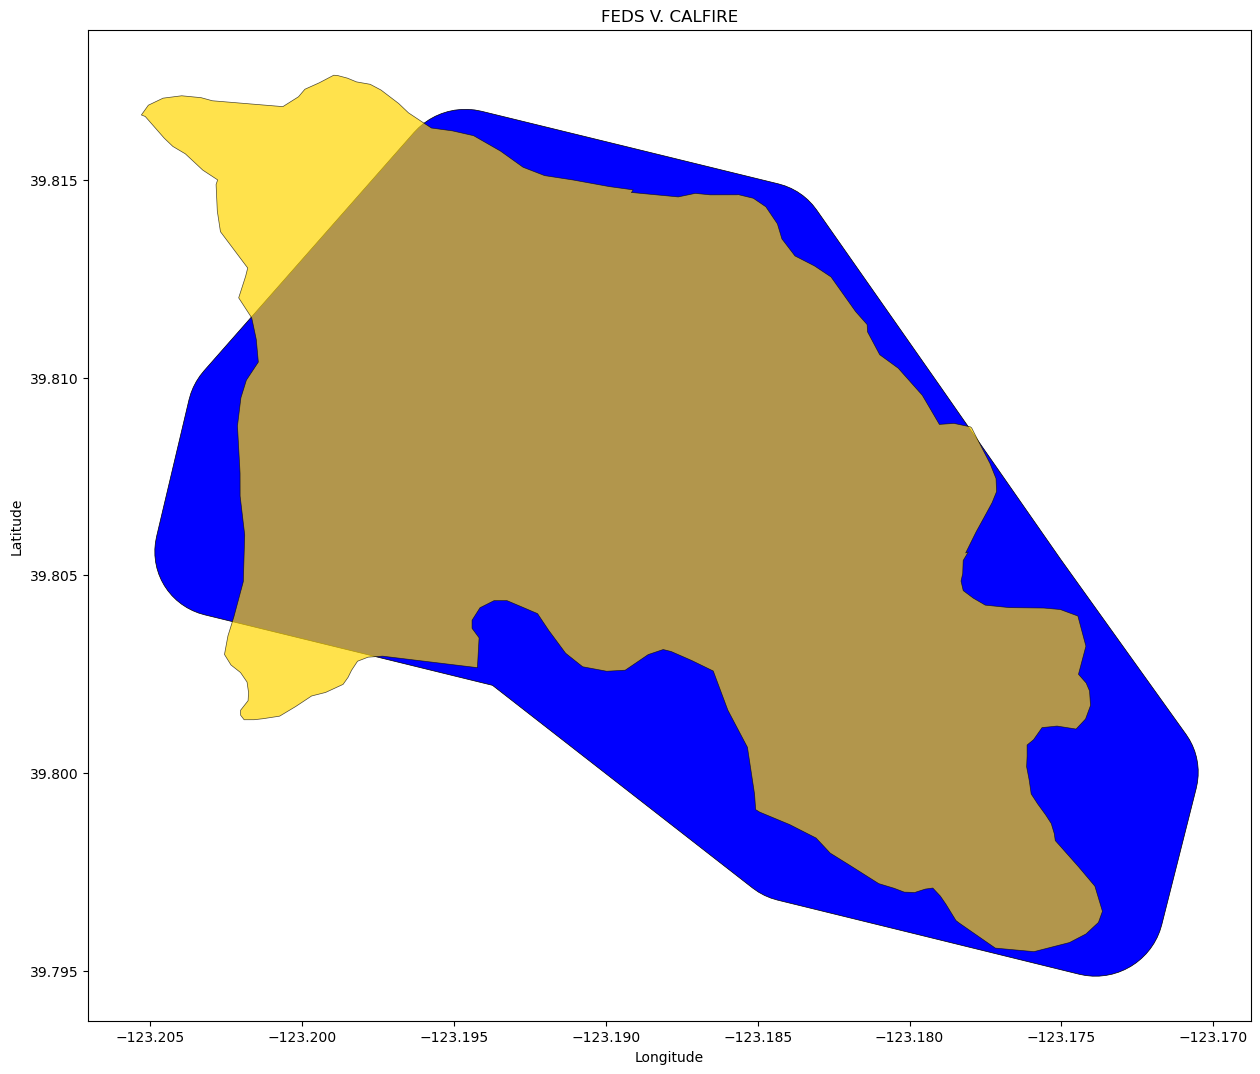

In [12]:
# visualize
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))

print('FEDS Polygon Date', feds_nrt_match['t'])
print('CALFIRE Polygon Date',nifc_current_match['DATE_CUR_STAMP'])


# search_bbox = ["-120.17", "38.18", "-119.67", "37.9"]
# lon_min, lat_max, lon_max, lat_min = map(float, search_bbox)

v = feds_nrt_match.plot(ax=ax, legend=True, label="FEDS MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = nifc_current_match.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)

# ax.set_xlim(lon_min, lon_max)
# ax.set_ylim(lat_min, lat_max)
ax.set_title("FEDS V. CALFIRE")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()
